<a href="https://colab.research.google.com/github/mirchandani-mohnish/ClusterMetrics/blob/main/kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from sklearn import datasets
import matplotlib.pyplot as plt
import kagglehub
import pandas as pd
import os
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import time
from sklearn.metrics import adjusted_rand_score, calinski_harabasz_score, davies_bouldin_score, mutual_info_score
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

In [7]:
seed = 0

In [8]:

def print_metrics(X, true_labels_values, predicted_labels):
    print("-------------------------------------------------------------------")
    true_labels = LabelEncoder().fit_transform(true_labels_values)
    # Silhouette Score
    try:
        print(f"Silhouette score: {silhouette_score(X, predicted_labels):.4f}")
    except Exception as e:
        print(f"Silhouette score failed: {str(e)}")

    # Adjusted Rand Score
    try:
        print(f"Adjusted Rand score: {adjusted_rand_score(true_labels, predicted_labels):.4f}")
    except Exception as e:
        print(f"Adjusted Rand score failed: {str(e)}")

    # Calinski-Harabasz Score
    try:
        print(f"Calinski-Harabasz score: {calinski_harabasz_score(X, predicted_labels):.4f}")
    except Exception as e:
        print(f"Calinski-Harabasz score failed: {str(e)}")

    # Davies-Bouldin Score
    try:
        print(f"Davies-Bouldin score: {davies_bouldin_score(X, predicted_labels):.4f}")
    except Exception as e:
        print(f"Davies-Bouldin score failed: {str(e)}")

    # Mutual Information Score
    try:
        print(f"Mutual Information score: {mutual_info_score(true_labels, predicted_labels):.4f}")
    except Exception as e:
        print(f"Mutual Information score failed: {str(e)}")


In [9]:
def k_means(X, k, max_iter=300, tol=1e-4):

    # Step 1: Initialize centroids randomly from the dataset
    n_samples, n_features = X.shape
    rng = np.random.default_rng(seed)
    centroids = X[rng.choice(n_samples, k, replace=False)]

    for _ in range(max_iter):
        # Step 2: Assign each data point to the nearest centroid
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        cluster_assignments = np.argmin(distances, axis=1)

        # Step 3: Compute new centroids
        new_centroids = np.array([X[cluster_assignments == j].mean(axis=0) if np.any(cluster_assignments == j) else centroids[j]
                                  for j in range(k)])

        # Step 4: Check for convergence
        if np.linalg.norm(new_centroids - centroids) < tol:
            break

        centroids = new_centroids

    return cluster_assignments, centroids


In [10]:
path = kagglehub.dataset_download("himanshunakrani/iris-dataset")
iris = pd.read_csv(os.path.join(path, "iris.csv"))
iris = iris.dropna()

iris_filtered = iris.select_dtypes(include=['float64'])

X_iris = iris_filtered.to_numpy()
k_iris = 3

print("Iris Dataset\n")

start_time = time.time()
labels_base_iris, centroids_base_iris = k_means(X_iris, k_iris)
print(f"Execution time (base): {time.time() - start_time} seconds")
print_metrics(X_iris, iris["species"], labels_base_iris)

start_time = time.time()
kmeans_iris = KMeans(n_clusters=k_iris, random_state=seed).fit(X_iris)
labels_sklearn_iris = kmeans_iris.labels_
centroids_sklearn_iris = kmeans_iris.cluster_centers_
print(f"\nExecution time (sklearn): {time.time() - start_time} seconds")
print_metrics(X_iris, iris["species"], labels_sklearn_iris)

Iris Dataset

Execution time (base): 0.002076387405395508 seconds
-------------------------------------------------------------------
Silhouette score: 0.5526
Adjusted Rand score: 0.7302
Calinski-Harabasz score: 560.3999
Davies-Bouldin score: 0.6623
Mutual Information score: 0.8256

Execution time (sklearn): 0.08751940727233887 seconds
-------------------------------------------------------------------
Silhouette score: 0.5510
Adjusted Rand score: 0.7163
Calinski-Harabasz score: 560.3660
Davies-Bouldin score: 0.6664
Mutual Information score: 0.8090


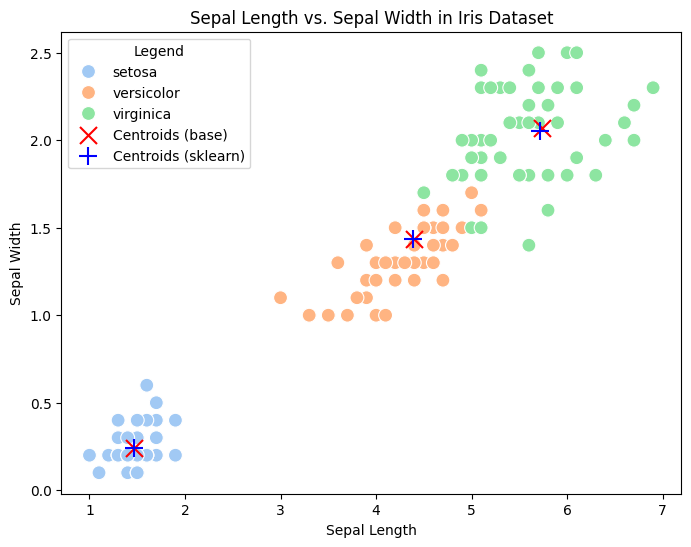

In [11]:
# centroids_base_iris = scaler_iris.inverse_transform(centroids_base_iris)
# centroids_sklearn_iris = scaler_iris.inverse_transform(centroids_sklearn_iris)

plength_idx = list(iris_filtered.columns).index("petal_length")
pwidth_idx = list(iris_filtered.columns).index("petal_width")

plt.figure(figsize=(8, 6))
sns.scatterplot(data=iris, x="petal_length", y="petal_width", hue="species", palette="pastel", s=100)
plt.scatter(centroids_base_iris[:, plength_idx], centroids_base_iris[:, pwidth_idx], c='red', marker='x', s=150, label='Centroids (base)')
plt.scatter(centroids_sklearn_iris[:, plength_idx], centroids_sklearn_iris[:, pwidth_idx], c='blue', marker='+', s=150, label='Centroids (sklearn)')

plt.xlabel("Sepal Length")
plt.ylabel("Sepal Width")
plt.title("Sepal Length vs. Sepal Width in Iris Dataset")
plt.legend(title="Legend")
plt.show()

In [12]:
from sklearn.preprocessing import OrdinalEncoder

path = kagglehub.dataset_download("katerynameleshenko/ai-index")
ai = pd.read_csv(os.path.join(path, "AI_index_db.csv"))
ai = ai.dropna()

ai["Total_score_Category"] = pd.cut(
    ai["Total score"],
    bins=[-float("inf"), 17.03, 26.91, float("inf")],
    labels=["Low", "Medium", "High"]
)
ai = ai.drop(columns=["Total score", "Country"])

ai_filtered = ai.drop(columns=["Total_score_Category"])

encoder = OrdinalEncoder()

categorical_cols = [col for col in ai_filtered.columns if ai_filtered[col].dtype not in [np.int64, np.float64]]
ai_filtered[categorical_cols] = encoder.fit_transform(ai_filtered[categorical_cols])

X_ai = ai_filtered.to_numpy()
k_ai = 3

print("AI Global Index")

start_time = time.time()
labels_base_ai, centroids_base_ai = k_means(X_ai, k_ai)
print(f"Execution time (base): {time.time() - start_time} seconds")
print_metrics(X_ai, ai["Total_score_Category"], labels_base_ai)

start_time = time.time()
kmeans_ai = KMeans(n_clusters=k_ai, random_state=seed).fit(X_ai)
labels_sklearn_ai = kmeans_ai.labels_
centroids_sklearn_ai = kmeans_ai.cluster_centers_
print(f"\nExecution time (sklearn): {time.time() - start_time} seconds")
print_metrics(X_ai, ai["Total_score_Category"], labels_sklearn_ai)

100%|██████████| 2.38k/2.38k [00:00<00:00, 3.86MB/s]

Extracting files...
AI Global Index
Execution time (base): 0.002063274383544922 seconds
-------------------------------------------------------------------
Silhouette score: 0.2640
Adjusted Rand score: 0.2632
Calinski-Harabasz score: 25.6946
Davies-Bouldin score: 1.2536
Mutual Information score: 0.3905

Execution time (sklearn): 0.00353240966796875 seconds
-------------------------------------------------------------------
Silhouette score: 0.2640
Adjusted Rand score: 0.2632
Calinski-Harabasz score: 25.6946
Davies-Bouldin score: 1.2536
Mutual Information score: 0.3905


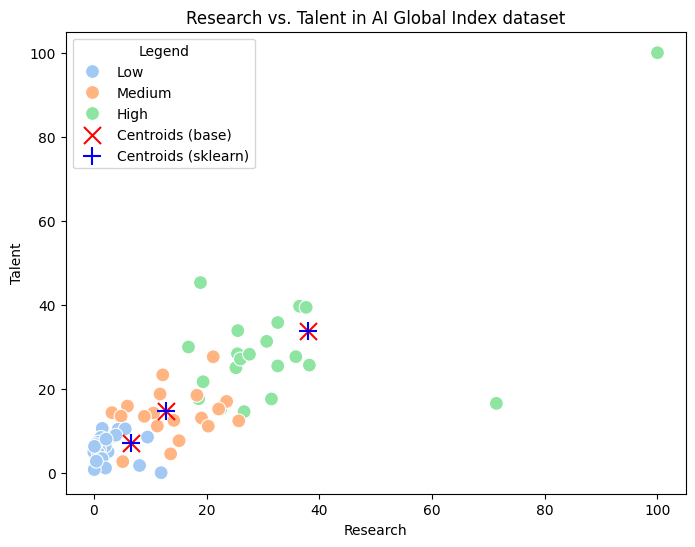

In [13]:
research_idx = list(ai_filtered.columns).index("Research")
talent_idx = list(ai_filtered.columns).index("Talent")

plt.figure(figsize=(8, 6))
sns.scatterplot(data=ai, x="Research", y="Talent", hue="Total_score_Category", palette="pastel", s=100)
plt.scatter(centroids_base_ai[:, research_idx], centroids_base_ai[:, talent_idx], c='red', marker='x', s=150, label='Centroids (base)')
plt.scatter(centroids_sklearn_ai[:, research_idx], centroids_sklearn_ai[:, talent_idx], c='blue', marker='+', s=150, label='Centroids (sklearn)')

plt.xlabel("Research")
plt.ylabel("Talent")
plt.title("Research vs. Talent in AI Global Index dataset")
plt.legend(title="Legend")
plt.show()

In [14]:
from sklearn.preprocessing import OrdinalEncoder

path = kagglehub.dataset_download("shreyasur965/recent-earthquakes")
earthquakes = pd.read_csv(os.path.join(path, "earthquakes.csv"))

earthquakes = earthquakes.drop(columns=["id", "type", "title", "date", "time", "updated", "url",
                                        "detailUrl", "status", "net", "code", "ids", "sources",
                                        "types", "geometryType", "place", "placeOnly", "location", "subnational", "city",
                                        "locality", "postcode", "what3words", "timezone", "locationDetails", "continent", "country"])

earthquakes = earthquakes.dropna()
earthquakes_filtered = earthquakes.drop(columns=['alert'])

encoder = OrdinalEncoder()

categorical_cols = [col for col in earthquakes_filtered.columns if earthquakes_filtered[col].dtype not in [np.int64, np.float64]]
earthquakes_filtered[categorical_cols] = encoder.fit_transform(earthquakes_filtered[categorical_cols])

X_earth = earthquakes_filtered.to_numpy()
k_earth = 4

print("Global Earthquake Data")

start_time = time.time()
labels_base_earth, centroids_base_earth = k_means(X_earth, k_earth)
print(f"Execution time (base): {time.time() - start_time} seconds")
print_metrics(X_earth, earthquakes["alert"], labels_base_earth)

start_time = time.time()
kmeans_earth = KMeans(n_clusters=k_earth, random_state=seed).fit(X_earth)
labels_sklearn_earth = kmeans_earth.labels_
centroids_sklearn_earth = kmeans_earth.cluster_centers_
print(f"\nExecution time (sklearn): {time.time() - start_time} seconds")
print_metrics(X_earth, earthquakes["alert"], labels_sklearn_earth)

100%|██████████| 214k/214k [00:00<00:00, 55.2MB/s]

Extracting files...
Global Earthquake Data
Execution time (base): 0.009081363677978516 seconds
-------------------------------------------------------------------
Silhouette score: 0.9486
Adjusted Rand score: -0.0247
Calinski-Harabasz score: 36082.4435
Davies-Bouldin score: 0.2272
Mutual Information score: 0.0011

Execution time (sklearn): 0.003871917724609375 seconds
-------------------------------------------------------------------
Silhouette score: 0.9486
Adjusted Rand score: -0.0247
Calinski-Harabasz score: 36082.4435
Davies-Bouldin score: 0.2272


Mutual Information score: 0.0011


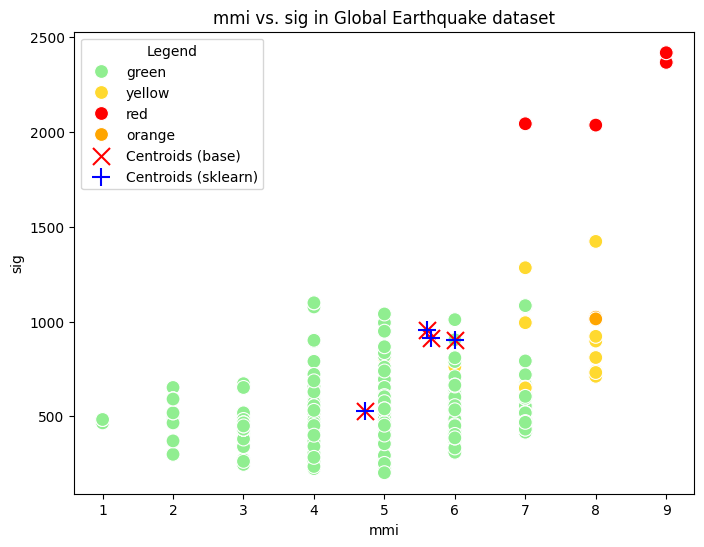

In [15]:
sig_idx = list(earthquakes_filtered.columns).index("sig")
mmi_idx = list(earthquakes_filtered.columns).index("mmi")

plt.figure(figsize=(8, 6))
sns.scatterplot(data=earthquakes, x="mmi", y="sig", hue="alert", palette={"green": "lightgreen", "orange": "orange", "red": "red", "yellow": sns.color_palette("Set2")[-3]}, s=100)
plt.scatter(centroids_base_earth[:, mmi_idx], centroids_base_earth[:, sig_idx], c='red', marker='x', s=150, label='Centroids (base)')
plt.scatter(centroids_sklearn_earth[:, mmi_idx], centroids_sklearn_earth[:, sig_idx], c='blue', marker='+', s=150, label='Centroids (sklearn)')

plt.xlabel("mmi")
plt.ylabel("sig")
plt.title("mmi vs. sig in Global Earthquake dataset")
plt.legend(title="Legend")
plt.show()

In [21]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

encoder = OrdinalEncoder()

alert_encoded = encoder.fit_transform(earthquakes["alert"].to_frame())
selector = SelectKBest(score_func=mutual_info_classif, k=5)

X_earth = selector.fit_transform(earthquakes_filtered, alert_encoded.ravel())
k_earth = 4

print("Global Earthquake Data")

start_time = time.time()
labels_base_earth, centroids_base_earth = k_means(X_earth, k_earth)
print(f"Execution time (base): {time.time() - start_time} seconds")
print_metrics(X_earth, earthquakes["alert"], labels_base_earth)

start_time = time.time()
kmeans_earth = KMeans(n_clusters=k_earth, random_state=seed).fit(X_earth)
labels_sklearn_earth = kmeans_earth.labels_
centroids_sklearn_earth = kmeans_earth.cluster_centers_
print(f"\nExecution time (sklearn): {time.time() - start_time} seconds")
print_metrics(X_earth, earthquakes["alert"], labels_sklearn_earth)

Global Earthquake Data
Execution time (base): 0.005975961685180664 seconds
-------------------------------------------------------------------
Silhouette score: 0.5682
Adjusted Rand score: 0.1113
Calinski-Harabasz score: 1345.5237
Davies-Bouldin score: 0.5957
Mutual Information score: 0.1233

Execution time (sklearn): 0.004117012023925781 seconds
-------------------------------------------------------------------
Silhouette score: 0.5682
Adjusted Rand score: 0.1113
Calinski-Harabasz score: 1345.5237
Davies-Bouldin score: 0.5957
Mutual Information score: 0.1233


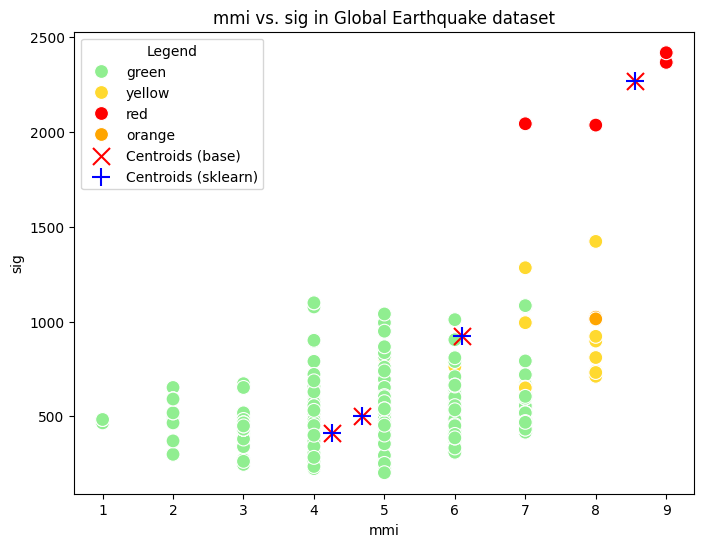

In [22]:
sig_idx = list(earthquakes_filtered.columns[selector.get_support()]).index("sig")
mmi_idx = list(earthquakes_filtered.columns[selector.get_support()]).index("mmi")

plt.figure(figsize=(8, 6))
sns.scatterplot(data=earthquakes, x="mmi", y="sig", hue="alert", palette={"green": "lightgreen", "orange": "orange", "red": "red", "yellow": sns.color_palette("Set2")[-3]}, s=100)
plt.scatter(centroids_base_earth[:, mmi_idx], centroids_base_earth[:, sig_idx], c='red', marker='x', s=150, label='Centroids (base)')
plt.scatter(centroids_sklearn_earth[:, mmi_idx], centroids_sklearn_earth[:, sig_idx], c='blue', marker='+', s=150, label='Centroids (sklearn)')

plt.xlabel("mmi")
plt.ylabel("sig")
plt.title("mmi vs. sig in Global Earthquake dataset")
plt.legend(title="Legend")
plt.show()

In [23]:
scores = selector.scores_
feature_ranking = sorted(zip(earthquakes_filtered.columns, scores), key=lambda x: x[1], reverse=True)
top_features = [f[0] for f in feature_ranking[:5]]
print("Top 5 Features Sorted by Importance:", top_features)

Top 5 Features Sorted by Importance: ['sig', 'mmi', 'longitude', 'latitude', 'magnitude']


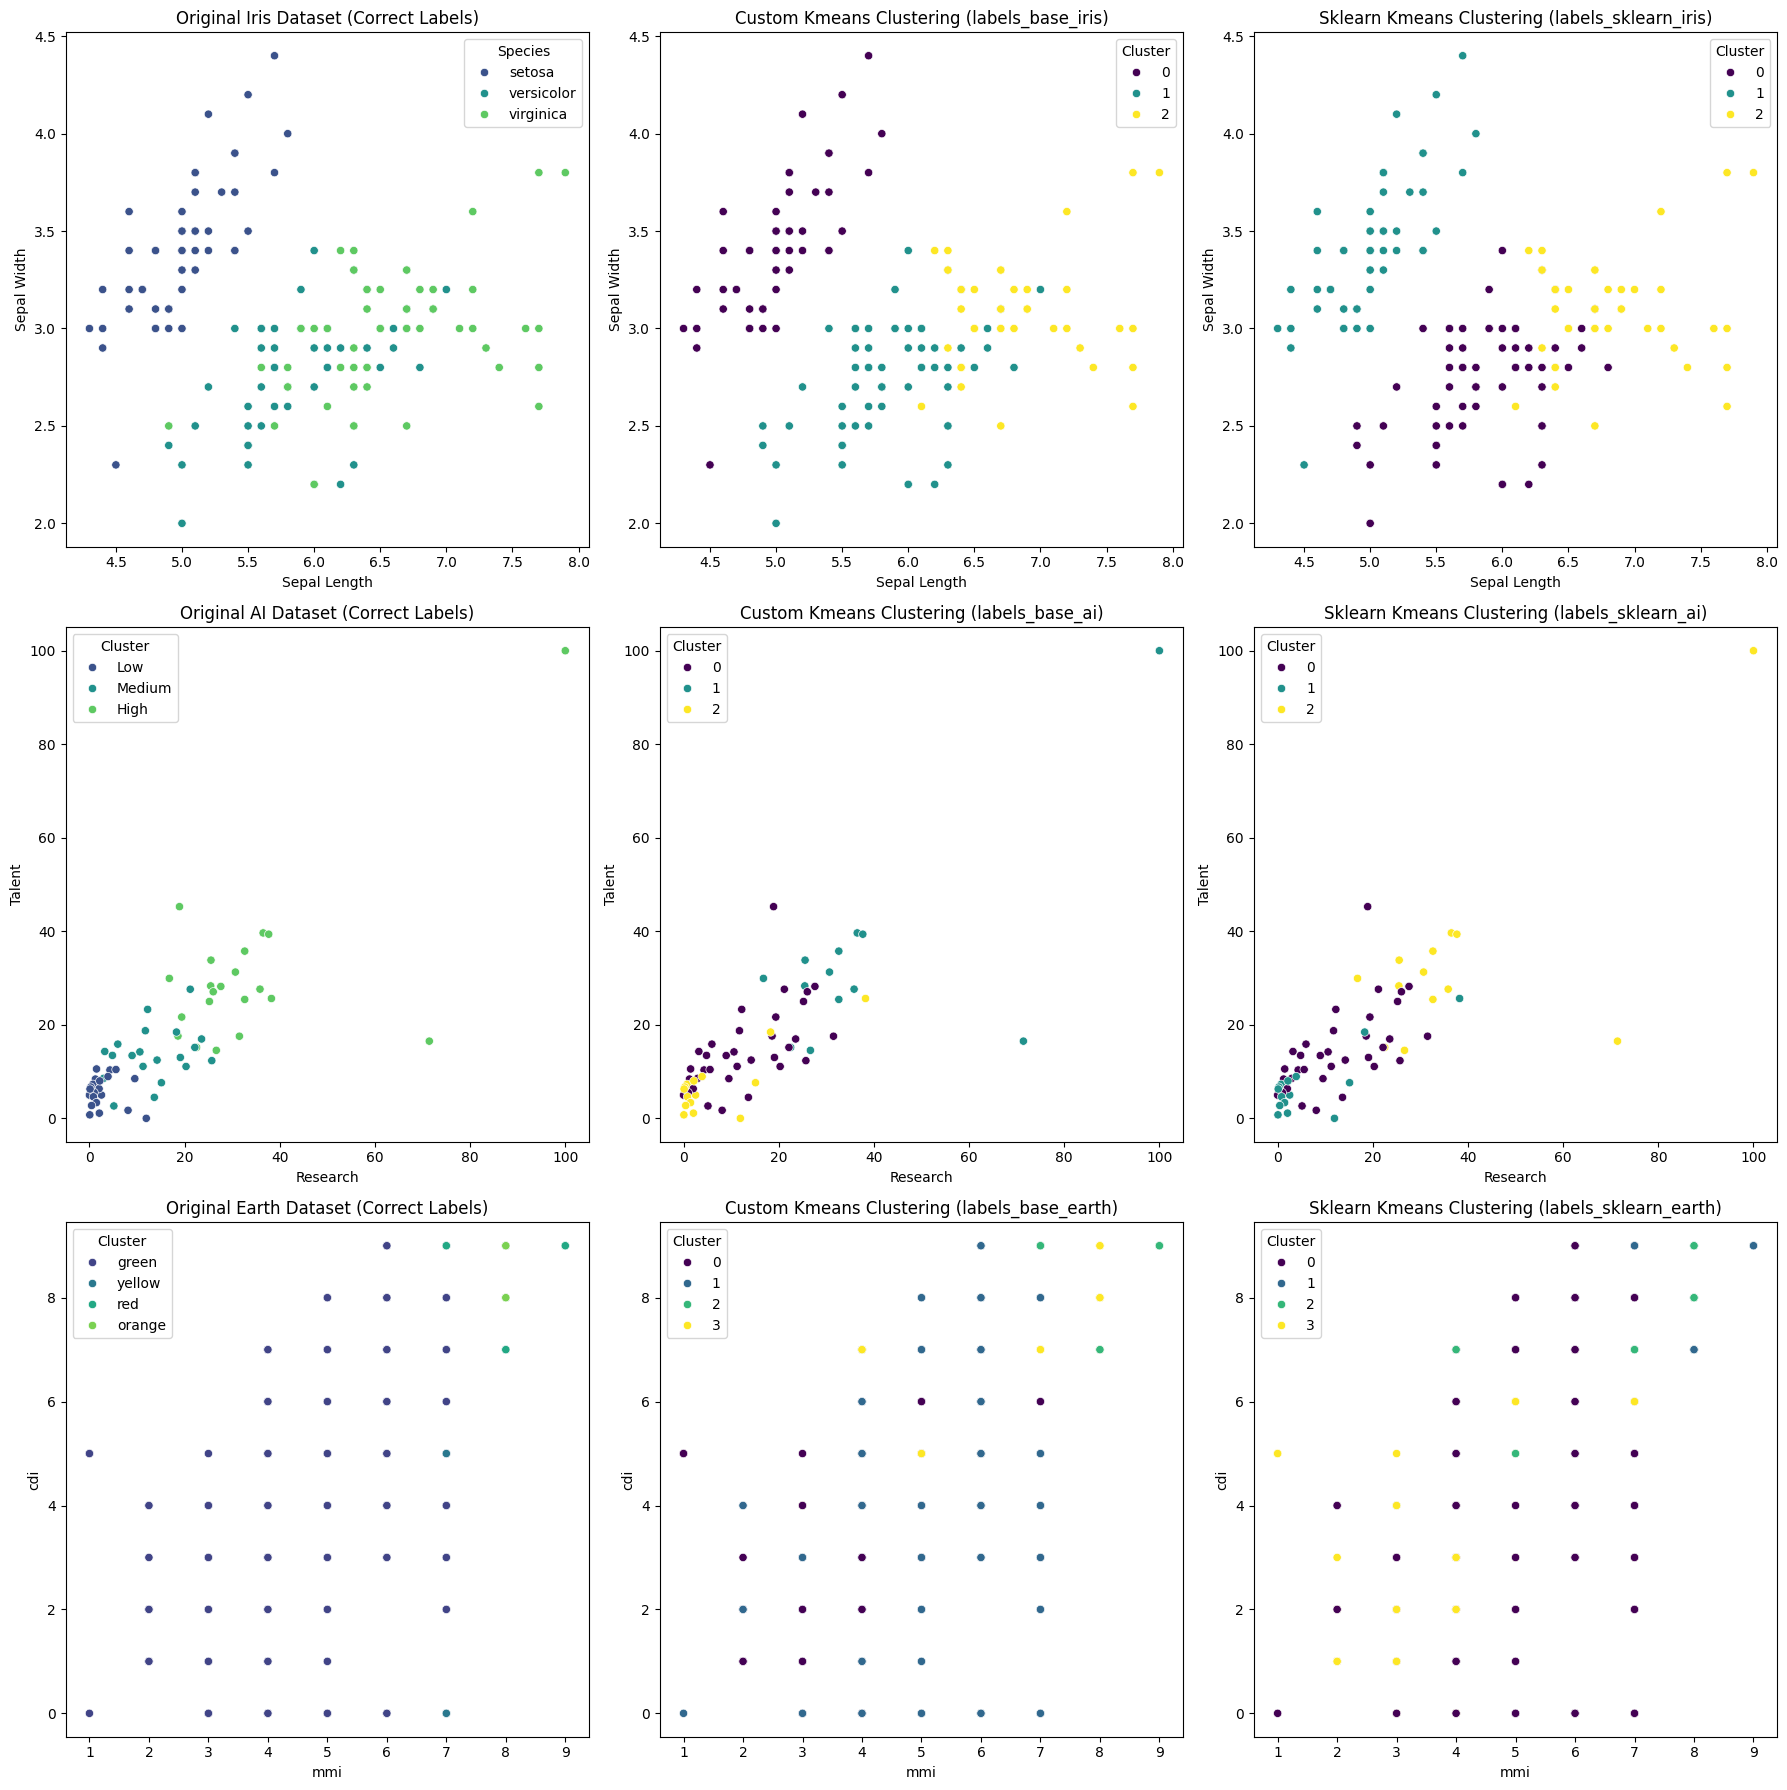

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with three subplots
fig, axes = plt.subplots(3, 3, figsize=(18, 18))

# Plot 1: Original Iris Dataset with Correct Labels
sns.scatterplot(data=iris, x="sepal_length", y="sepal_width", hue="species", palette="viridis", ax=axes[0][0])
axes[0][0].set_title("Original Iris Dataset (Correct Labels)")
axes[0][0].set_xlabel("Sepal Length")
axes[0][0].set_ylabel("Sepal Width")
axes[0][0].legend(title="Species")

# Plot 2: Custom DBSCAN Labels (labels_base_iris)
sns.scatterplot(data=iris, x="sepal_length", y="sepal_width", hue=labels_base_iris, palette="viridis", ax=axes[0][1])
axes[0][1].set_title("Custom Kmeans Clustering (labels_base_iris)")
axes[0][1].set_xlabel("Sepal Length")
axes[0][1].set_ylabel("Sepal Width")
axes[0][1].legend(title="Cluster")

# Plot 3: Sklearn DBSCAN Labels (labels_sklearn_iris)
sns.scatterplot(data=iris, x="sepal_length", y="sepal_width", hue=labels_sklearn_iris, palette="viridis", ax=axes[0][2])
axes[0][2].set_title("Sklearn Kmeans Clustering (labels_sklearn_iris)")
axes[0][2].set_xlabel("Sepal Length")
axes[0][2].set_ylabel("Sepal Width")
axes[0][2].legend(title="Cluster")

# Plot 1: Original Iris Dataset with Correct Labels
sns.scatterplot(data=ai, x="Research", y="Talent", hue="Total_score_Category", palette="viridis", ax=axes[1][0])
axes[1][0].set_title("Original AI Dataset (Correct Labels)")
axes[1][0].set_xlabel("Research")
axes[1][0].set_ylabel("Talent")
axes[1][0].legend(title="Cluster")

# Plot 2: Custom OPTICS Labels (labels_base_ai)
sns.scatterplot(data=ai, x="Research", y="Talent", hue=labels_base_ai, palette="viridis", ax=axes[1][1])
axes[1][1].set_title("Custom Kmeans Clustering (labels_base_ai)")
axes[1][1].set_xlabel("Research")
axes[1][1].set_ylabel("Talent")
axes[1][1].legend(title="Cluster")

# Plot 3: Sklearn OPTICS Labels (labels_sklearn_ai)
sns.scatterplot(data=ai, x="Research", y="Talent", hue=labels_sklearn_ai, palette="viridis", ax=axes[1][2])
axes[1][2].set_title("Sklearn Kmeans Clustering (labels_sklearn_ai)")
axes[1][2].set_xlabel("Research")
axes[1][2].set_ylabel("Talent")
axes[1][2].legend(title="Cluster")


# Plot 1: Original Iris Dataset with Correct Labels
sns.scatterplot(data=earthquakes, x="mmi", y="cdi", hue="alert", palette="viridis", ax=axes[2][0])
axes[2][0].set_title("Original Earth Dataset (Correct Labels)")
axes[2][0].set_xlabel("mmi")
axes[2][0].set_ylabel("cdi")
axes[2][0].legend(title="Cluster")

# Plot 2: Custom DBSCAN Labels (labels_base_ai)
sns.scatterplot(data=earthquakes, x="mmi", y="cdi", hue=labels_base_earth, palette="viridis", ax=axes[2][1])
axes[2][1].set_title("Custom Kmeans Clustering (labels_base_earth)")
axes[2][1].set_xlabel("mmi")
axes[2][1].set_ylabel("cdi")
axes[2][1].legend(title="Cluster")

# Plot 3: Sklearn DBSCAN Labels (labels_sklearn_ai)
sns.scatterplot(data=earthquakes, x="mmi", y="cdi", hue=labels_sklearn_earth, palette="viridis", ax=axes[2][2])
axes[2][2].set_title("Sklearn Kmeans Clustering (labels_sklearn_earth)")
axes[2][2].set_xlabel("mmi")
axes[2][2].set_ylabel("cdi")
axes[2][2].legend(title="Cluster")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()